In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.options.display.max_columns=100

In [2]:
df=pd.read_csv('csv_files/Invistico_Airline.csv')

In [3]:
df.sample(5)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
34160,dissatisfied,Loyal Customer,31,Personal Travel,Business,3304,4,4,3,1,3,3,3,3,3,5,3,4,4,3,0,0.0
127351,satisfied,Loyal Customer,33,Business travel,Eco,1533,5,4,4,4,5,5,5,5,3,3,3,5,5,5,0,0.0
123155,satisfied,Loyal Customer,40,Business travel,Eco,2763,5,3,3,3,5,5,5,5,4,2,4,4,4,5,0,3.0
34452,dissatisfied,Loyal Customer,45,Personal Travel,Eco,740,4,4,4,1,4,5,1,3,3,4,4,2,3,4,0,0.0
107712,satisfied,Loyal Customer,49,Business travel,Business,803,1,1,1,1,5,4,4,4,4,4,4,5,4,4,3,4.0


In [4]:
df.isna().mean()[df.isna().mean()*100!=0]

Arrival Delay in Minutes    0.003026
dtype: float64

In [5]:
df=df.dropna()

In [6]:
df.nunique()

satisfaction                            2
Customer Type                           2
Age                                    75
Type of Travel                          2
Class                                   3
Flight Distance                      5397
Seat comfort                            6
Departure/Arrival time convenient       6
Food and drink                          6
Gate location                           6
Inflight wifi service                   6
Inflight entertainment                  6
Online support                          6
Ease of Online booking                  6
On-board service                        6
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Cleanliness                             6
Online boarding                         6
Departure Delay in Minutes            464
Arrival Delay in Minutes              472
dtype: int64

In [7]:
df['satisfaction']=df['satisfaction'].apply(lambda x:1 if x=='satisfied' else 0)

In [8]:
for col in df.select_dtypes('O').columns:
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

In [9]:
# building ML Model

In [10]:
X=df.drop(columns='satisfaction')
y=df['satisfaction']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [11]:
from xgboost import XGBClassifier
model=XGBClassifier()

In [12]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model):
    train_sizes,train_scores,test_scores=learning_curve(
        X=X_train,
        y=y_train,
        estimator=model,
        train_sizes=np.linspace(0.1,1,10),
        cv=3,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='red')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title('Learning Curve for XGBoost Classifier')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

[learning_curve] Training set sizes: [ 6905 13811 20717 27623 34529 41435 48341 55247 62153 69059]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.9s finished


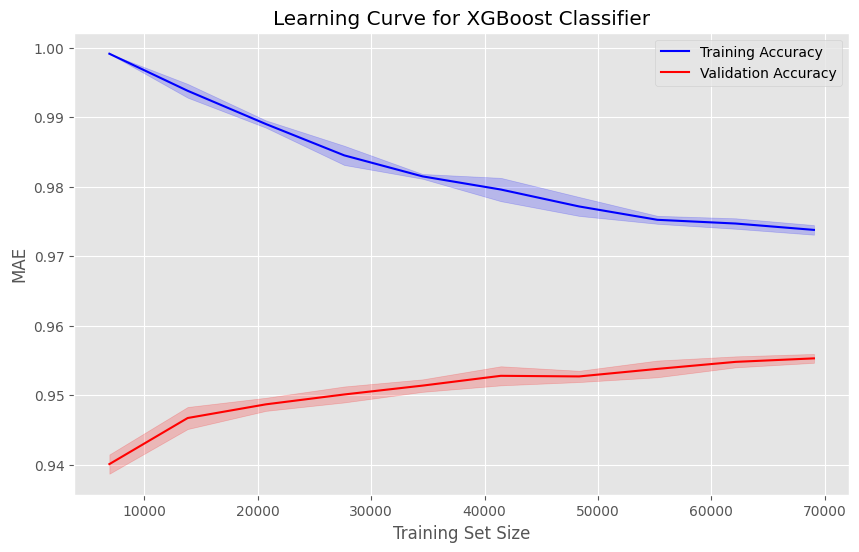

CPU times: total: 953 ms
Wall time: 27.6 s


In [13]:
%%time
plot_learning_curve(model)

In [14]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
train_prediction=model.predict(X_train)
test_prediction=model.predict(X_test)

In [16]:
from sklearn import metrics
accuracy_train=metrics.accuracy_score(train_prediction,y_train)
accuracy_test=metrics.accuracy_score(test_prediction,y_test)
print('Train and Test Accuracies: ',accuracy_train,accuracy_test)

Train and Test Accuracies:  0.9699775072642848 0.9542821839524288


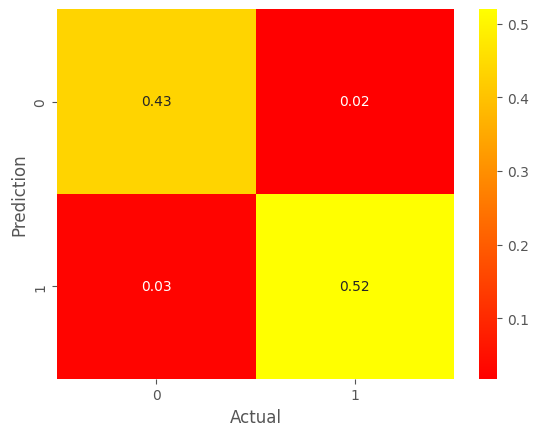

In [17]:
cm=metrics.confusion_matrix(y_test,test_prediction)
cm_percentage=cm/cm.sum()

sns.heatmap(cm_percentage,annot=True,fmt='.2f',cmap='autumn')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

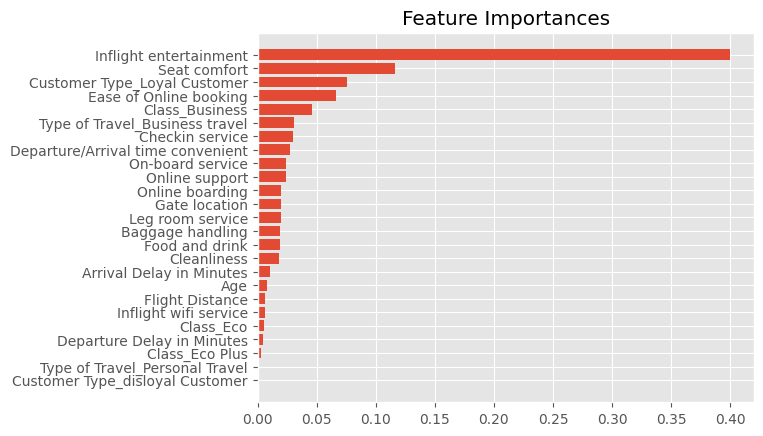

In [33]:
importances=model.feature_importances_
features=model.feature_names_in_

importances_dict={k:v for k,v in zip(features,importances)}
importances_dict = dict(sorted(importances_dict.items(), key=lambda item: item[1],reverse=False))

plt.barh(y=[k for k,v in importances_dict.items()],
         width=[v for k,v in importances_dict.items()])
plt.title('Feature Importances')
plt.show()